In [1]:
# --- Importación de Librerías ---
from IPython import get_ipython
from IPython.display import display
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
from pycaret.classification import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix


# User auth
auth.authenticate_user()


# Configurar cliente de BigQuery
project_id = 'machine-learning-pr'
client = bigquery.Client(project=project_id,location='US')



In [2]:

# get the data set and table

dataset_ref = client.dataset('ds1', project='machine-learning-pr')
table_ref = dataset_ref.table('tbl_hr_data')
table1 = client.get_table(table_ref)
print(table1.schema)

new_table_ref = dataset_ref.table('new_employees')
table2 = client.get_table(new_table_ref)
print(table2.schema)

[SchemaField('satisfaction_level', 'FLOAT', 'NULLABLE', None, None, (), None), SchemaField('last_evaluation', 'FLOAT', 'NULLABLE', None, None, (), None), SchemaField('number_project', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('average_montly_hours', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('time_spend_company', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('Work_accident', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('Quit_the_Company', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('promotion_last_5years', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('Departments', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('salary', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('employee_id', 'STRING', 'NULLABLE', None, None, (), None)]
[SchemaField('satisfaction_level', 'FLOAT', 'NULLABLE', None, None, (), None), SchemaField('last_evaluation', 'FLOAT', 'NULLABLE', None, None, (), None), SchemaF

In [3]:
# Convert to dataframe
df1 = client.list_rows(table1).to_dataframe()
df1['Quit_the_Company'] = df1['Quit_the_Company'].astype(bool)
df2 = client.list_rows(table2).to_dataframe()
df1.describe()
df1['Quit_the_Company'].value_counts()


,count
Quit_the_Company,
False,11428
True,3576


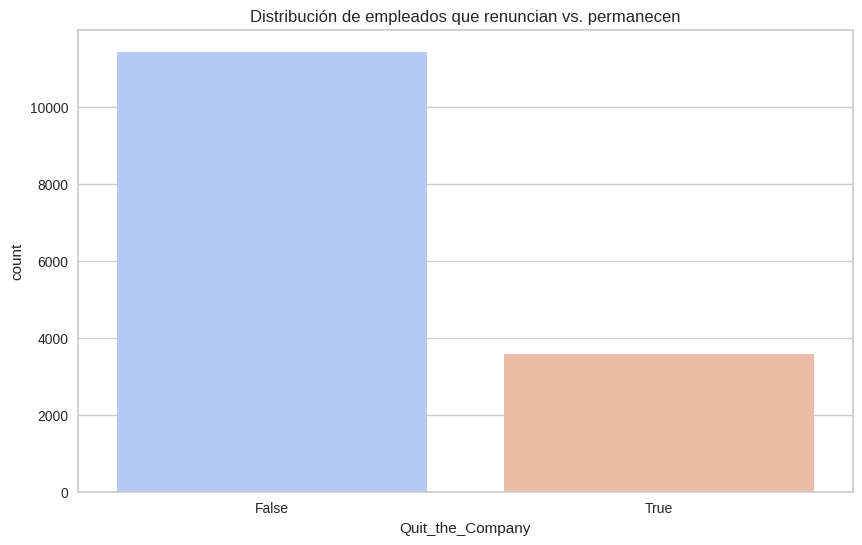

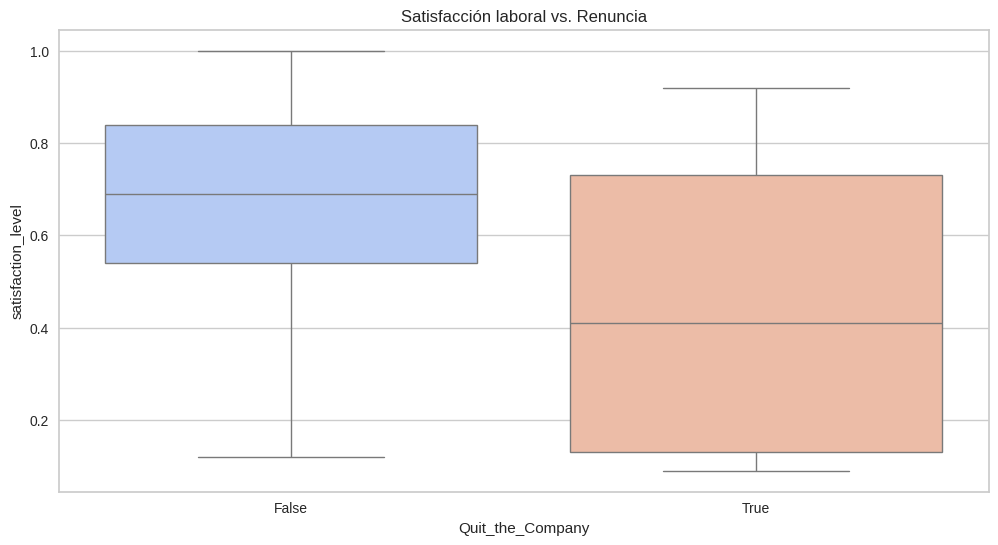

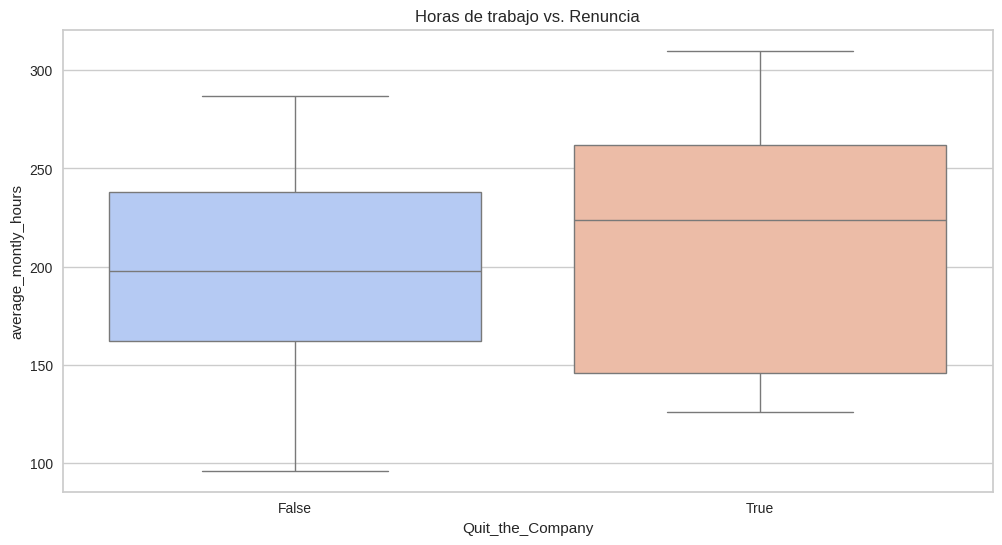

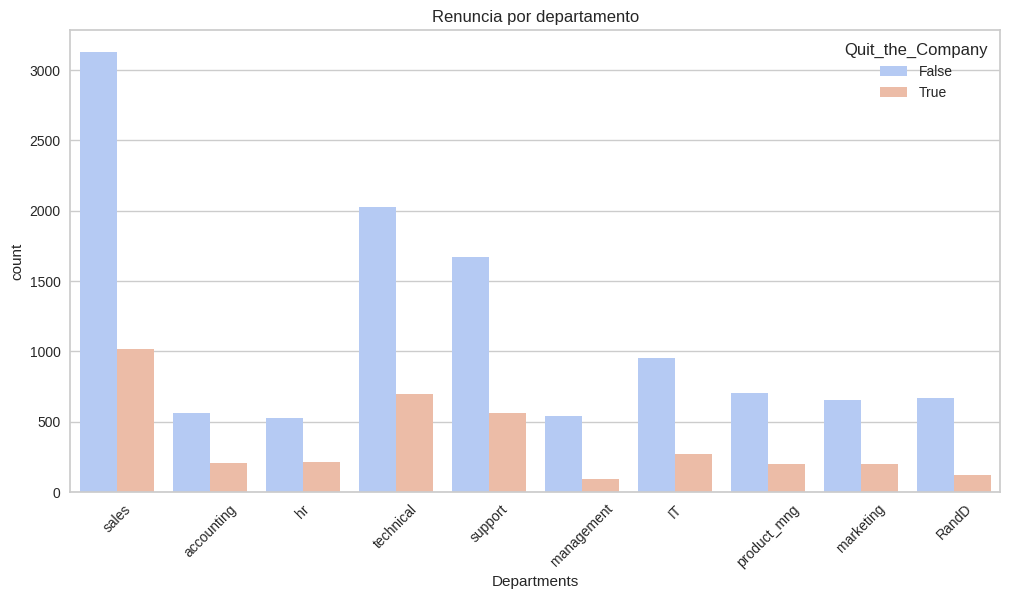

In [4]:
# Visualización de datos
plt.figure(figsize=(10, 6))
sns.countplot(x='Quit_the_Company', data=df1, palette='coolwarm')
plt.title('Distribución de empleados que renuncian vs. permanecen')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Quit_the_Company', y='satisfaction_level', data=df1, palette='coolwarm')
plt.title('Satisfacción laboral vs. Renuncia')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Quit_the_Company', y='average_montly_hours', data=df1, palette='coolwarm')
plt.title('Horas de trabajo vs. Renuncia')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='Departments', hue='Quit_the_Company', data=df1, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Renuncia por departamento')
plt.show()


In [6]:
# Setup PyCaret obj('Quit_the_Company')
clf = setup(df1,
            target='Quit_the_Company',
            session_id=123,
            ignore_features=['employee_id'],
            categorical_features=['salary','Departments'])



,Description,Value
0,Session id,123
1,Target,Quit_the_Company
2,Target type,Binary
3,Original data shape,"(15004, 11)"
4,Transformed data shape,"(15004, 21)"
5,Transformed train set shape,"(10502, 21)"
6,Transformed test set shape,"(4502, 21)"
7,Ignore features,1
8,Numeric features,7
9,Categorical features,2


In [7]:
# Comparar modelos
best_model = compare_models()



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9881,0.9910,0.9585,0.9913,0.9746,0.9668,0.9671,0.6920
lightgbm,Light Gradient Boosting Machine,0.9853,0.9932,0.9505,0.9876,0.9686,0.9591,0.9594,0.4190
xgboost,Extreme Gradient Boosting,0.9852,0.9921,0.9581,0.9797,0.9687,0.9590,0.9592,0.3410
et,Extra Trees Classifier,0.9840,0.9908,0.9505,0.9820,0.9658,0.9554,0.9557,0.6710
gbc,Gradient Boosting Classifier,0.9765,0.9891,0.9313,0.9689,0.9496,0.9343,0.9347,1.0850
dt,Decision Tree Classifier,0.9747,0.9698,0.9605,0.9354,0.9476,0.9310,0.9312,0.1110
ada,Ada Boost Classifier,0.9584,0.9830,0.9085,0.9167,0.9123,0.8851,0.8853,0.4180
knn,K Neighbors Classifier,0.9343,0.9687,0.9205,0.8246,0.8698,0.8260,0.8284,0.2590
qda,Quadratic Discriminant Analysis,0.8749,0.9154,0.8086,0.7169,0.7566,0.6734,0.6784,0.1200
lr,Logistic Regression,0.7932,0.8178,0.3584,0.6129,0.4516,0.3351,0.3536,1.1230


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9848,0.9860,0.9442,0.9916,0.9673,0.9574,0.9579
1,0.9819,0.9939,0.9442,0.9793,0.9615,0.9497,0.9499
2,0.9924,0.9959,0.9760,0.9919,0.9839,0.9789,0.9789
3,0.9876,0.9871,0.9600,0.9877,0.9736,0.9655,0.9657
4,0.9848,0.9926,0.9400,0.9958,0.9671,0.9572,0.9578
5,0.9924,0.9932,0.9680,1.0000,0.9837,0.9788,0.9790
6,0.9876,0.9897,0.9640,0.9837,0.9737,0.9656,0.9657
7,0.9924,0.9908,0.9720,0.9959,0.9838,0.9788,0.9789
8,0.9895,0.9891,0.9640,0.9918,0.9777,0.9708,0.9710


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

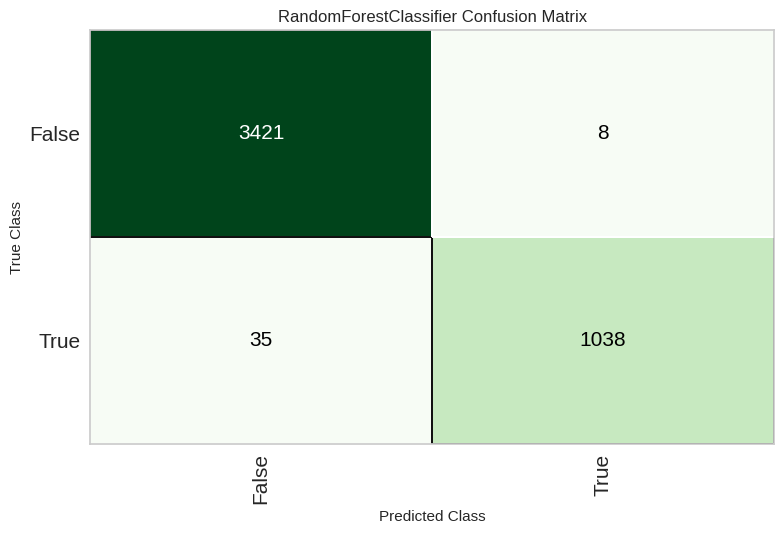

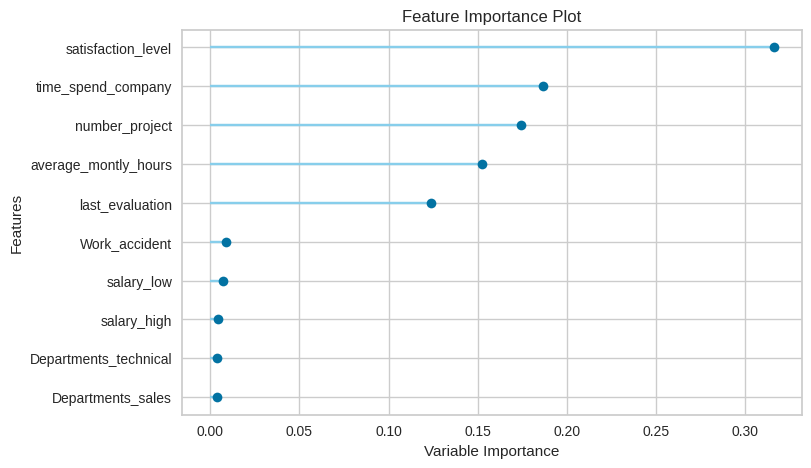

In [8]:
# Crear el mejor modelo
final_model = create_model(best_model)
# Evaluar el modelo

plot_model(final_model, plot='confusion_matrix')
plot_model(final_model, plot='feature')

In [9]:
predictions = predict_model(final_model, data=df2)
predictions['prediction_score'] = predictions['prediction_score'].astype(int)
predictions.head()



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9300,0,0.0000,0.0000,0.0000,0.0000,0.0000


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,Departments,salary,employee_id,Quit_the_Company,prediction_label,prediction_score
0,0.537849,0.122914,2,208,2,0,0,IT,high,NE15043,0,0,1
1,0.056211,0.322600,2,229,5,1,0,IT,low,NE15086,0,0,0
2,0.555186,0.555949,2,187,3,0,0,RandD,medium,NE15035,0,0,0
3,0.605273,0.713086,2,218,3,0,0,RandD,high,NE15069,0,0,1
4,0.043437,0.162372,2,175,3,0,0,RandD,high,NE15082,0,0,0


In [10]:
final_model.feature_names_in_

array(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'Departments_management',
       'Departments_product_mng', 'Departments_sales', 'Departments_IT',
       'Departments_technical', 'Departments_RandD',
       'Departments_support', 'Departments_hr', 'Departments_marketing',
       'Departments_accounting', 'salary_medium', 'salary_low',
       'salary_high'], dtype=object)

In [11]:
final_model.feature_importances_

array([0.31590926, 0.12397999, 0.17444144, 0.15228352, 0.18648895,
       0.00879937, 0.00166611, 0.00162452, 0.00118108, 0.00371594,
       0.00168   , 0.00380856, 0.00161397, 0.00297005, 0.00182668,
       0.00127811, 0.00163246, 0.00362204, 0.00697355, 0.0045044 ])

In [12]:
# Get feature importance from the final_model
feature_importance = pd.DataFrame({'Feature': final_model.feature_names_in_,
                                   'Importance': final_model.feature_importances_})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Export to GBQ
table_id = 'machine-learning-pr.ds1.feature_importances'
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE"
)
job = client.load_table_from_dataframe(
    feature_importance, table_id, job_config=job_config
)
job.result()  # Wait for the job to complete

print(f"Feature importances loaded to {table_id}")


Feature importances loaded to machine-learning-pr.ds1.feature_importances


In [13]:
# Guardar predicciones en BigQuery
predictions.to_gbq(destination_table='machine-learning-pr.ds1.new_employees_predictions', project_id='machine-learning-pr', if_exists='replace')

print("Modelo entrenado y predicciones guardadas exitosamente en BigQuery.")


100%|██████████| 1/1 [00:00<00:00, 8630.26it/s]

Modelo entrenado y predicciones guardadas exitosamente en BigQuery.
